# Predicting Performance of Top Ranked PUBG Players
<p style="font-size:18px">A Machine Learning Experiment Using KNearest Neighbors</p>

<img src="pubg-image.jpg" alt="PUBG">

**Problem:** Predicting performance given by `squad_Losses` player statistic

This document presents an analysis of the performance of top ranked PlayerUnknown's Battlegrounds players from <https://pubgtracker.com/> with the objective to classify a player as `HIGH-PERFORMING` or `LOW-PERFORMING` PUBG gamer and predict an individual player's **number of losses** in games played in the game's <u>**SQUAD**</u> mode.

** Highlights of the Results: **
1. Distance travelled features positively correlates most with squad losses
2. KNN Classfier using n_neighbors = 13 labeled player's performance at 94.72 accuracy. 
3. KNN Regression using n_neighbors = 7 reliably predicted squad losses at approximately 90% accuracy
4. Reducing movement and camping are recommended playing strategies to reduce losses

## About PlayerUnknown's BattleGrounds  
#### The Best Multiplayer Game 
PlayerUnknown's Battegrounds is a new online multiplayer battle royale game developed by PUBG Corporation currently available on desktop, Xbox One, and mobile. Early beta access to the game started March 2017 with a full release on December the same year. Even in beta, it has won "Best Multiplayer Game" and nominated for "Game of the Year" and "Best Ongoing Game" at The Game Awards 2017. <sup>[1]</sup>

#### Batte Royale Inspired Gameplay
Inspired by the file *Battle Royale*, the gameplaye involves up to 100 players who parachute onto an island and scavange for weapons and equipment to kill others while avoiding getting killed themselves. The available safe area of the game's map diminished in size over time, forcing surviving players into smaller areas. Each area in the map features different terrain and randomly placed weapons and equipment. The last player or team standing wins the round.


<img src="pubg-map.jpg" alt="PlayerUnknown's Battlegrounds Erangel Map" width="400" height="400">

#### <center>PlayerUnknown's Battlegrounds Erangel Map</center>

#### Solo, Duo, Squad Game Modes
Being a large-scale last man standing deathmatch, PUBG has three main game modes:


| Mode       | No. of Players in Team    | No. of Opponent Teams  |
| :------------- :|:-------------:| :-----:|
| SOLO   | 1 | 99 |
| DUO   | 2 | 50 |
| SQUAD   | 4 | 25 |

Based on the data, <u>**SQUAD**</u> mode is played the most, garnering the highest average number of rounds played by players. 


In [223]:
import pandas as pd
df_pubg = pd.read_csv('PUBG_Player_Statistics.csv')

In [224]:
print('Mean SOLO Rounds Played: {0:.2f}'.format(df_pubg['solo_RoundsPlayed'].mean()))
print('Mean DUO Rounds Played: {0:.2f}'.format(df_pubg['duo_RoundsPlayed'].mean()))
print('Mean SQUAD Rounds Played: {0:.2f}'.format(df_pubg['squad_RoundsPlayed'].mean()))

Mean SOLO Rounds Played: 79.28
Mean DUO Rounds Played: 112.02
Mean SQUAD Rounds Played: 181.81


## About the Data

The data downloaded from <https://www.kaggle.com/lorenzopagliaro01/pubg-dataset-analysis/data> contains data of approximately 85,000 of the top ranked PUBG players with 150 numerical features categorized by game modes (SOLO, DUO, SQUAD)

The dataframe below shows the 48 recurring player attributes for each game mode attached with a unique `player_name` and `tracker_id`.

In [225]:
pd.DataFrame([df_pubg.columns.tolist()[2:14],df_pubg.columns.tolist()[14:26],
            df_pubg.columns.tolist()[26:38],df_pubg.columns.tolist()[38:50]]).T

,0,1,2,3
0,solo_KillDeathRatio,solo_HeadshotKillsPg,solo_TeamKills,solo_MostSurvivalTime
1,solo_WinRatio,solo_HealsPg,solo_HeadshotKills,solo_AvgSurvivalTime
2,solo_TimeSurvived,solo_KillsPg,solo_HeadshotKillRatio,solo_WinPoints
3,solo_RoundsPlayed,solo_MoveDistancePg,solo_VehicleDestroys,solo_WalkDistance
4,solo_Wins,solo_RevivesPg,solo_RoadKills,solo_RideDistance
5,solo_WinTop10Ratio,solo_RoadKillsPg,solo_DailyKills,solo_MoveDistance
6,solo_Top10s,solo_TeamKillsPg,solo_WeeklyKills,solo_AvgWalkDistance
7,solo_Top10Ratio,solo_TimeSurvivedPg,solo_RoundMostKills,solo_AvgRideDistance
8,solo_Losses,solo_Top10sPg,solo_MaxKillStreaks,solo_LongestKill
9,solo_Rating,solo_Kills,solo_WeaponAcquired,solo_Heals


## Questions we would like to ask

Focusing on the performance of players who played <u>**SQUAD**</u> games, particularly in terms of `squad_Losses`, some of the questions we would like to ask are the following:
1. Which player statistics/attributes correlate most with `squad_Losses`?
2. Is it possible to predict a player's performance given his/her player statistics? 
3. What gameplay strategies can be followed by PUBG players given the data?


## Results of Analysis

### Initialization & Data Loading
Appropriate libraries were initialized and the PUBG dataset was separated into feature and target `squad_Losses` dataframes.

In [226]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

#import mglearn 

#### Sampling the dataset

In [227]:
target = 'squad_Losses'
n_rows = 15000

df_sampled = df_pubg.sample(n=n_rows, random_state = 143)

#### Separating feature and target for KNearest Neighbors Classification

In [228]:
X_clf = df_sampled.iloc[:,-50:]
y_clf = df_sampled[target][:n_rows]
X_clf.drop(target, axis = 1, inplace = True)

#### Encoding continuous target variables to categorical

In [229]:
y_clf_ = []

for i in range(len(y_clf)):
    if y_clf.iloc[i]>=y_clf.describe()['75%']: y_clf_.append('Low-Performing')
    else: y_clf_.append('High-Performing')

#### Separating feature and target for regression

In [230]:
X_reg = df_sampled.iloc[:,-50:]
y_reg = df_sampled[target][:n_rows]
X_reg.drop(target, axis = 1, inplace = True)

### Data Exploration
With knowledge from playing PUBG, some player statistics/attributes were selected for pairplot visualization. 

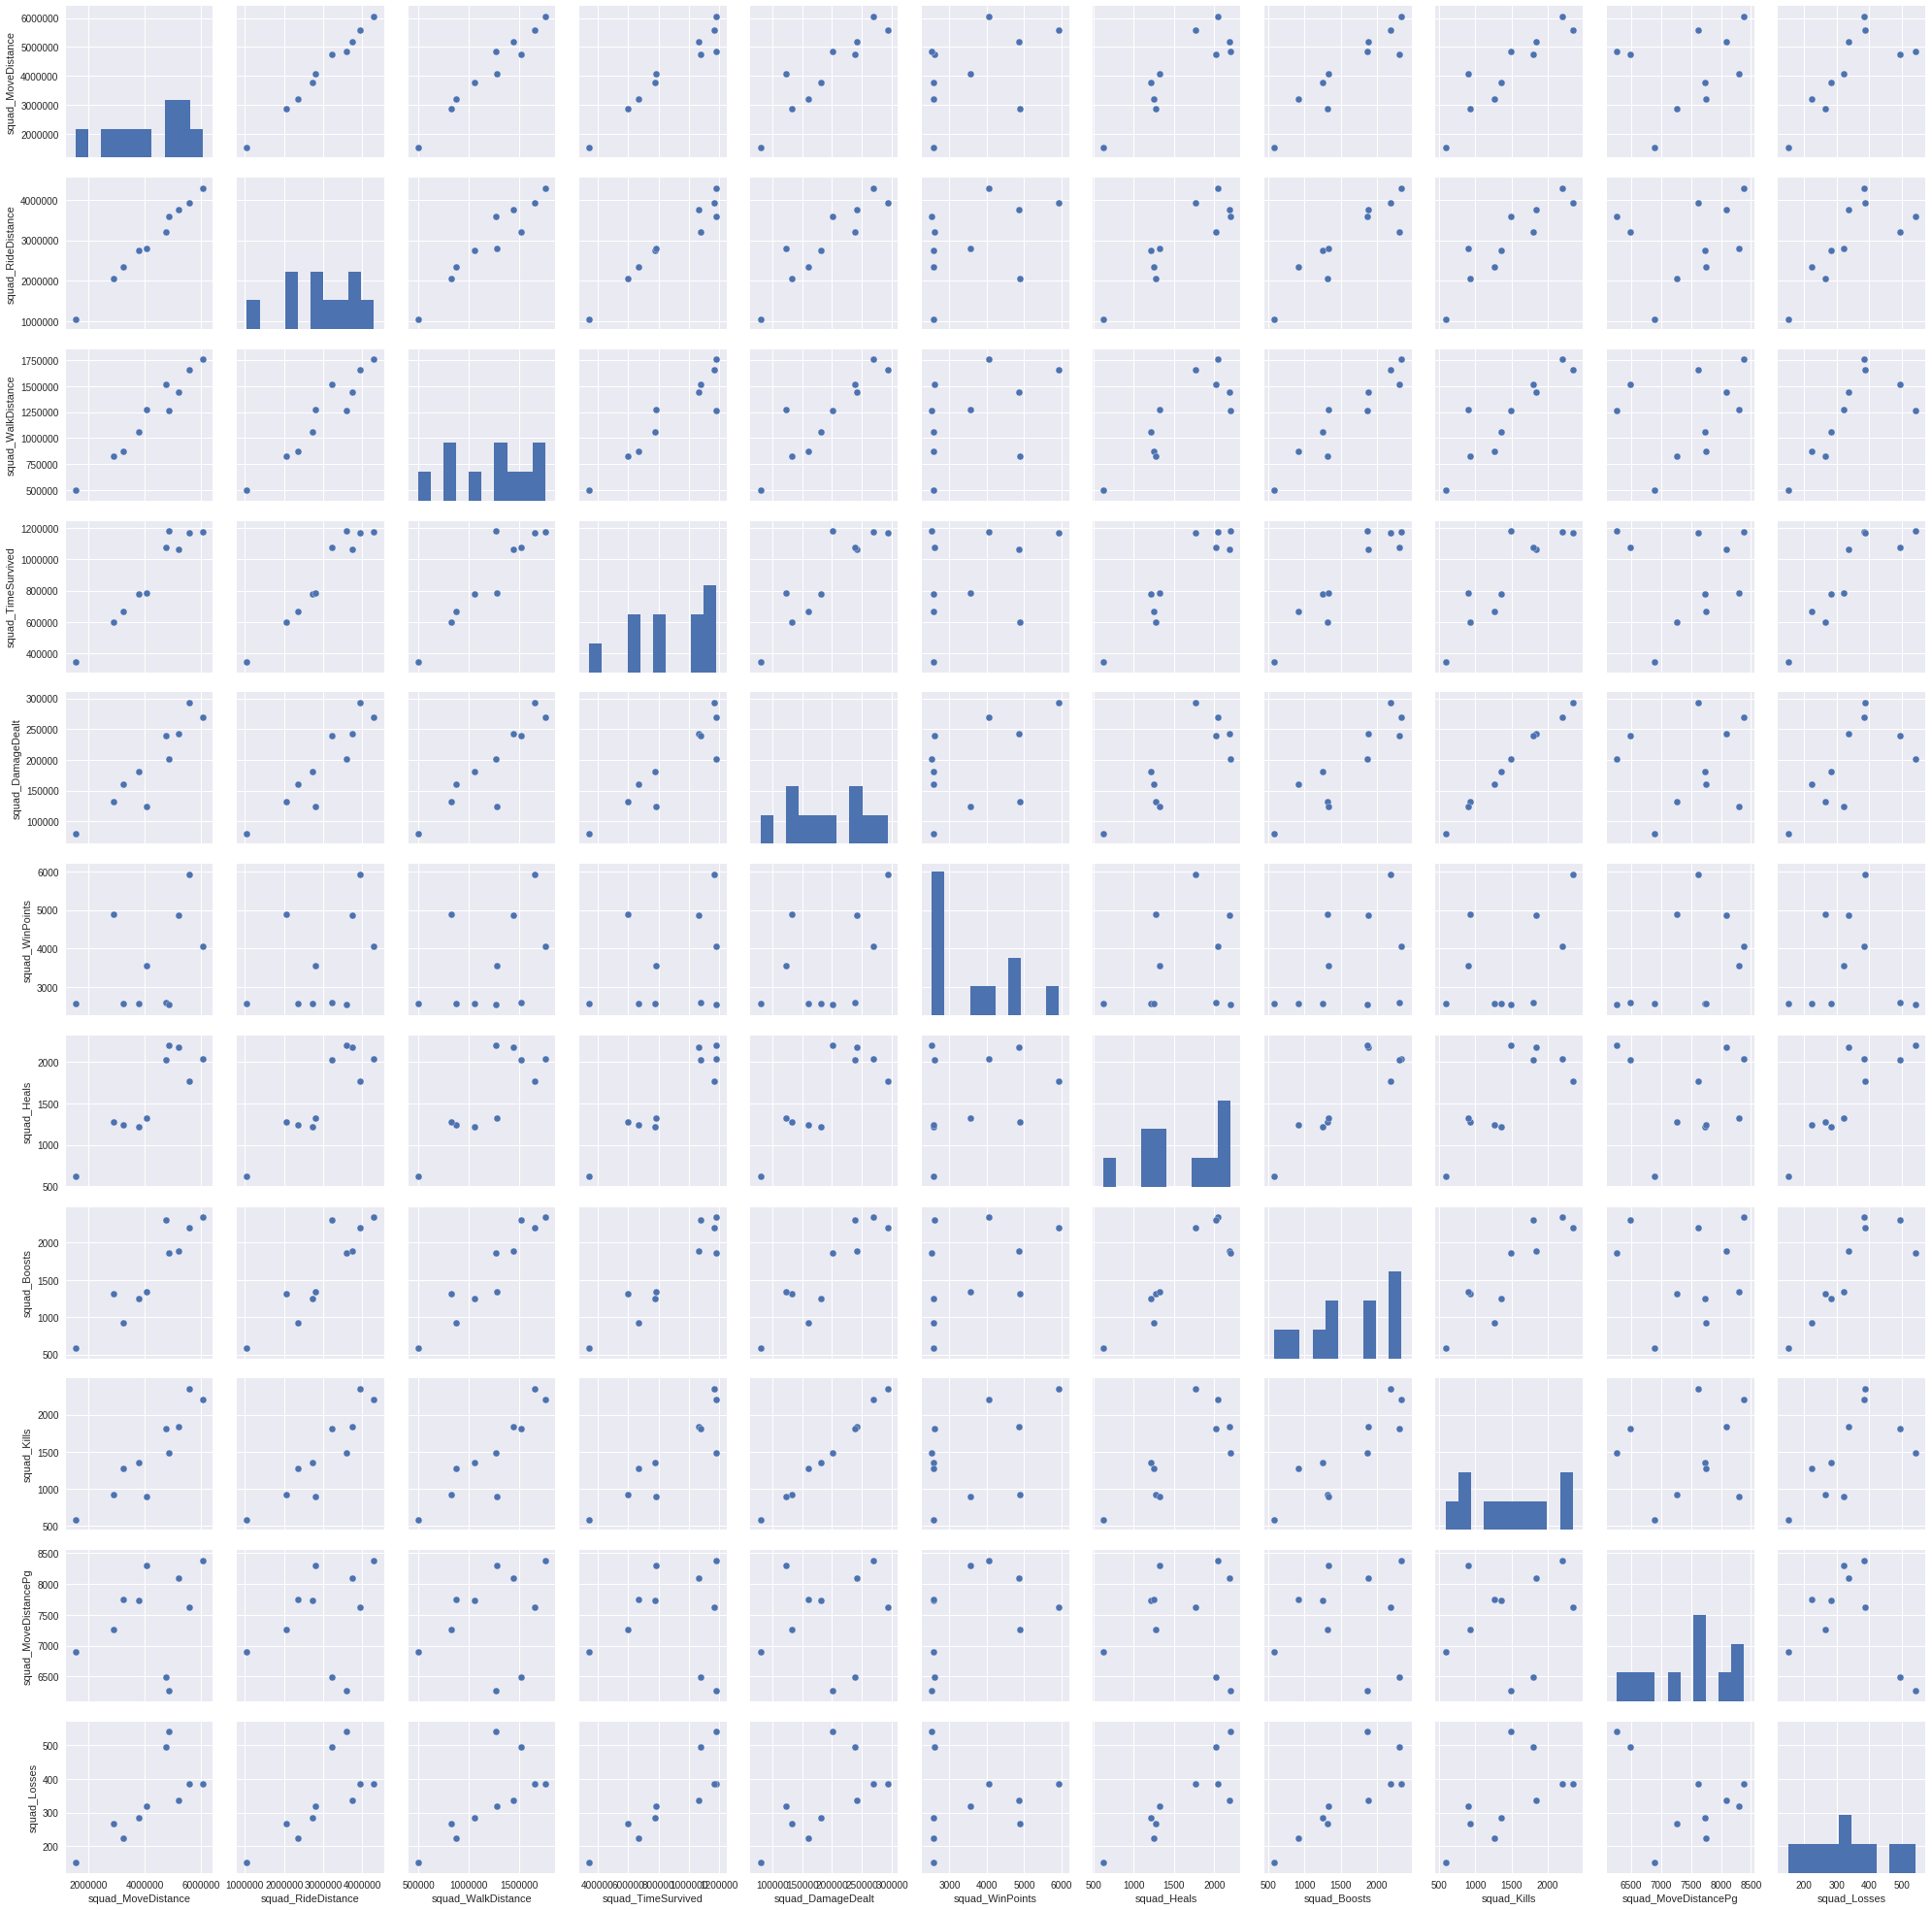

In [6]:
sns.pairplot(df_pubg[['squad_MoveDistance','squad_RideDistance','squad_WalkDistance',
        'squad_TimeSurvived','squad_DamageDealt','squad_WinPoints',
        'squad_Heals','squad_Boosts','squad_Kills','squad_MoveDistancePg','squad_Losses']][:10])

**Observations:** It appears that there is a generally increasing trend when `squad_losses` is plotted against distance travelled attributes such as `squad_MoveDistance`, `squad_RideDistance` and `squad_WalkDistance`

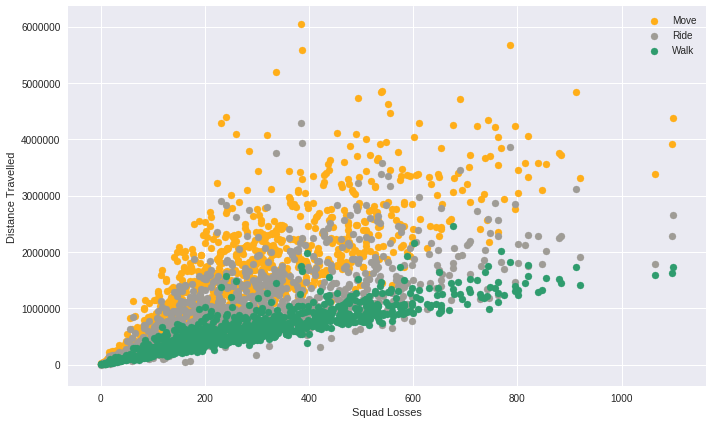

In [7]:
plt.figure(figsize=(10,6))
plt.scatter(df_pubg['squad_Losses'][:1000], df_pubg['squad_MoveDistance'][:1000], c='#ffae19', label = 'Move')
plt.scatter(df_pubg['squad_Losses'][:1000], df_pubg['squad_RideDistance'][:1000], c='#9f9c96', label = 'Ride')
plt.scatter(df_pubg['squad_Losses'][:1000], df_pubg['squad_WalkDistance'][:1000], c='#2f9c6e', label = 'Walk')
plt.xlabel('Squad Losses')
plt.ylabel('Distance Travelled')
plt.legend()
plt.tight_layout()

### Feature Selection & Dimensionality Reduction
Using in-game knowledge, heuristics, and Principal Component Analysis, the most significant feature variables were identified. 

In [217]:
n_significant = 4
pca = PCA(n_components = 2).fit(X_clf)

feat_significant_df = pd.DataFrame({"Feature Names":X_clf.columns.tolist(), 
                                 "PCA-1 Weights": abs(pca.components_[0])
                                }).sort_values(by='PCA-1 Weights', ascending= 
                                               False)

feat_significant = pd.DataFrame({"Feature Names":X_clf.columns.tolist(), 
                                 "PCA-1 Weights": abs(pca.components_[0])
                                }).sort_values(by='PCA-1 Weights', ascending= 
                                               False).iloc[:n_significant,0
                                                          ].values.tolist()
X_clf_ = X_clf[feat_significant]
X_clf_.columns.tolist()

['squad_MoveDistance',
 'squad_RideDistance',
 'squad_WalkDistance',
 'squad_TimeSurvived']

In [218]:
n_significant = 4
pca = PCA(n_components = 2).fit(X_reg)

feat_significant_df = pd.DataFrame({"Feature Names":X_reg.columns.tolist(), 
                                 "PCA-1 Weights": abs(pca.components_[0])
                                }).sort_values(by='PCA-1 Weights', ascending= 
                                               False)

feat_significant = pd.DataFrame({"Feature Names":X_reg.columns.tolist(), 
                                 "PCA-1 Weights": abs(pca.components_[0])
                                }).sort_values(by='PCA-1 Weights', ascending= 
                                               False).iloc[:n_significant,0
                                                          ].values.tolist()
X_reg_ = X_reg[feat_significant]
X_reg_.columns.tolist()

['squad_MoveDistance',
 'squad_RideDistance',
 'squad_WalkDistance',
 'squad_TimeSurvived']

In [219]:
print("PCA-1 Variance Ratio Explained: {0:.4f}".format(pca.explained_variance_ratio_[0]))
print("PCA-1 Top Features: {}".format(feat_significant))

PCA-1 Variance Ratio Explained: 0.9808
PCA-1 Top Features: ['squad_MoveDistance', 'squad_RideDistance', 'squad_WalkDistance', 'squad_TimeSurvived']


**Observations:** The distance features above are used as predictor features for both classifier and regressor below. This reduction seems reasonable given the trend observed in the data exploration wherein the distance features correlate highly with `squad_Losses`. 

### KNN Classification

With the objective to fit a classifier, the proportional chance criterion needs to be calculated to take into account the data label's distribution and its effect to the succeeding model accuracies. 

In [232]:
from collections import Counter

state_counts = Counter(y_clf_)
df_state = pd.DataFrame.from_dict(state_counts, orient='index')
#df_state.plot.bar()
num=(df_state[0]/df_state[0].sum())**2
print("Population per class: {}\n".format(df_state))
print("1.25 * Proportion Chance Criterion: {}%".format(1.25*100*num.sum()))

Population per class:                      0
High-Performing  11245
Low-Performing    3755

1.25 * Proportion Chance Criterion: 78.08336111111112%


**Observations:** The subsequent classification model to be developed should have an accuracy greater than **78.08%** for it to be considered as a good classifier.

Using a test size of 0.25, the fitted KNN Classification model was able to classify players performance with more than **94% test accuracy** given the selected predictor feature variables. 

In [233]:
n_neighbors = 6
random_state = 234

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_clf_, y_clf_, test_size = 0.25, 
                                                    random_state = random_state)

knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, y_train)

print("KNN Regressor (n_neighbors: {}) Test Accuracy: {}".format(n_neighbors, knn_clf.score(X_test, y_test)))
print("KNN Regressor (n_neighbors: {}) Train Accuracy: {}".format(n_neighbors, knn_clf.score(X_train, y_train)))


KNN Regressor (n_neighbors: 6) Test Accuracy: 0.9426666666666667
KNN Regressor (n_neighbors: 6) Train Accuracy: 0.9575111111111111


In [234]:
def plot_n_neighbors_clf(feat, targ, title, nmax=70, step=10, max_rstate=100, test_size=0.25):
    
    training_accuracy = []
    test_accuracy = []
    training_std = []
    test_std = []
    n_neighbors_list = []
    neighbors_settings = range(1, nmax, step)
    random_states = range(1,max_rstate)

    for n_neighbors in neighbors_settings:
        knn_clf = KNeighborsClassifier(n_neighbors=n_neighbors)    
        train_acc_per_trial = []
        test_acc_per_trial = []
        
        for random_state in random_states:
            # split training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(feat,
                                                        targ, 
                                                        test_size=test_size,
                                                        random_state=random_state)
            # build the model
            knn_clf.fit(X_train, y_train)
            
            # training set accuracy per trial
            train_acc_per_trial.append(knn_clf.score(X_train, y_train))
            # testing set accuracy per trial
            test_acc_per_trial.append(knn_clf.score(X_test, y_test))
        
        # record ave training accuracy    
        training_accuracy.append(np.mean(train_acc_per_trial))
        # record ave testing accuracy
        test_accuracy.append(np.mean(test_acc_per_trial))
        # record training std
        training_std.append(np.std(train_acc_per_trial))
        # record testing std
        test_std.append(np.std(test_acc_per_trial))
        
        n_neighbors_list.append(n_neighbors)

        
    results = pd.DataFrame([n_neighbors_list,training_accuracy, test_accuracy, 
                            training_std, test_std]).T
    results.columns = ['n_neighbors', 'mean train score', 'mean test score', 
                       'train std', 'test std']

    # plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
    # plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
    plt.errorbar(neighbors_settings, training_accuracy, 
                 yerr=training_std, 
                 label="training accuracy" )
    plt.errorbar(neighbors_settings, test_accuracy, yerr=test_std, 
                 label="test accuracy" )
    plt.ylabel("Accuracy")
    plt.xlabel("n_neighbors")
    plt.title(title)
    plt.legend()    
    return results

,n_neighbors,mean train score,mean test score,train std,test std
0,1.0,1.000000,0.930874,0.000000,0.003753
1,3.0,0.966941,0.941894,0.001142,0.003490
2,5.0,0.960707,0.944294,0.001214,0.003444
3,7.0,0.956980,0.945285,0.001408,0.003278
4,9.0,0.955012,0.946244,0.001314,0.003197
5,11.0,0.954093,0.946747,0.001248,0.003401
6,13.0,0.953267,0.947235,0.001206,0.003336
7,15.0,0.952521,0.947243,0.001180,0.003620
8,17.0,0.951703,0.947009,0.001247,0.003507
9,19.0,0.951193,0.946885,0.001217,0.003449


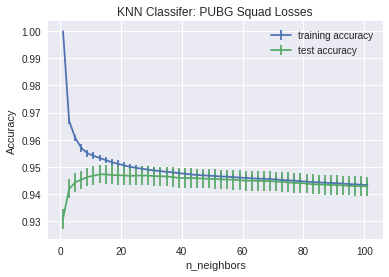

In [235]:
plot_n_neighbors_clf(X_clf_, y_clf_, 'KNN Classifer: PUBG Squad Losses', nmax=102, step=2, max_rstate=100, test_size=0.25)

**Observation:** Based on the plot of mean test accuracy in 100 random states with varying number of neighbors above, the optimal number of neigbors is determined to be: **13**. A decrease in both mean training and test accuracy was observed after seven neighbors though all classifiers up to 100 neighbors resulted to accuracies greater than 94%.

### KNN Regression Analysis

Using a test size of 0.25, the fitted KNN Regression model was able to predict `squad_Losses` of players with more than **90% test accuracy** given the selected predictor feature variables. 

In [158]:
X_reg_ = X_reg[['squad_MoveDistance', 'squad_RideDistance', 'squad_WalkDistance', 'squad_TimeSurvived']]

In [237]:
n_neighbors = 7
random_state = 234

X_train, X_test, y_train, y_test = train_test_split(X_reg_, y_reg, test_size = 0.25, 
                                                    random_state = random_state)

knn_reg = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X_train, y_train)

print("KNN Regressor (n_neighbors: {}) Test Accuracy: {}".format(n_neighbors, knn_reg.score(X_test, y_test)))
print("KNN Regressor (n_neighbors: {}) Train Accuracy: {}".format(n_neighbors, knn_reg.score(X_train, y_train)))


KNN Regressor (n_neighbors: 7) Test Accuracy: 0.930022977461513
KNN Regressor (n_neighbors: 7) Train Accuracy: 0.9495144785350941


### KNN Regression Analysis: Identifying the optimal n_neighbors

In [11]:
def plot_n_neighbors_reg(feat, targ, title, nmax=70, step=10, max_rstate=100, test_size=0.25):
    
    training_accuracy = []
    test_accuracy = []
    training_std = []
    test_std = []
    n_neighbors_list = []
    neighbors_settings = range(1, nmax, step)
    random_states = range(1,max_rstate)

    for n_neighbors in neighbors_settings:
        knn_reg = KNeighborsRegressor(n_neighbors=n_neighbors)    
        train_acc_per_trial = []
        test_acc_per_trial = []
        
        for random_state in random_states:
            # split training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(feat,
                                                        targ, 
                                                        test_size=test_size,
                                                        random_state=random_state)
            # build the model
            knn_reg.fit(X_train, y_train)
            
            # training set accuracy per trial
            train_acc_per_trial.append(knn_reg.score(X_train, y_train))
            # testing set accuracy per trial
            test_acc_per_trial.append(knn_reg.score(X_test, y_test))
        
        # record ave training accuracy    
        training_accuracy.append(np.mean(train_acc_per_trial))
        # record ave testing accuracy
        test_accuracy.append(np.mean(test_acc_per_trial))
        # record training std
        training_std.append(np.std(train_acc_per_trial))
        # record testing std
        test_std.append(np.std(test_acc_per_trial))
        
        n_neighbors_list.append(n_neighbors)

        
    results = pd.DataFrame([n_neighbors_list,training_accuracy, test_accuracy, 
                            training_std, test_std]).T
    results.columns = ['n_neighbors', 'mean train score', 'mean test score', 
                       'train std', 'test std']

    # plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
    # plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
    plt.errorbar(neighbors_settings, training_accuracy, 
                 yerr=training_std, 
                 label="training accuracy" )
    plt.errorbar(neighbors_settings, test_accuracy, yerr=test_std, 
                 label="test accuracy" )
    plt.ylabel("Accuracy")
    plt.xlabel("n_neighbors")
    plt.title(title)
    plt.legend()    
    return results

,n_neighbors,mean train score,mean test score,train std,test std
0,1.0,1.000000,0.840053,0.000000,0.007726
1,3.0,0.946520,0.892612,0.001171,0.005083
2,5.0,0.935228,0.901893,0.001348,0.004280
3,7.0,0.929866,0.905224,0.001338,0.004302
4,9.0,0.926374,0.906698,0.001309,0.004376
5,11.0,0.923953,0.907344,0.001413,0.004533
6,13.0,0.921968,0.907595,0.001425,0.004490
7,15.0,0.920410,0.907777,0.001426,0.004455
8,17.0,0.919223,0.907771,0.001398,0.004343
9,19.0,0.918074,0.907648,0.001390,0.004359


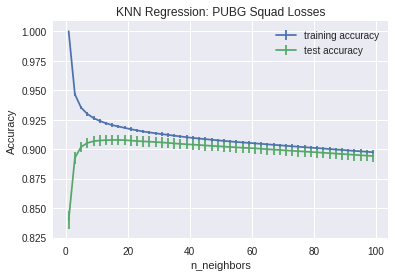

In [13]:
plot_n_neighbors_reg(X_reg, y_reg, 'KNN Regression: PUBG Squad Losses', nmax=102, step=2, max_rstate=102, test_size=0.25)

**Observation:** Based on the plot of mean test accuracy in 100 random states with varying number of neighbors above, the optimal number of neigbors is determined to be: 7. A decrease in both mean training and test accuracy was observed after seven neighbors though all regressors up to 100 neighbors resulted to accuracies greater than 89%.

## Summary
Using KNearest Neighbors Classification and Regression, the performance of a player in <u>**SQUAD**</u> game mode given by the number of his/her losses `squad_Losses` can be reliably predicted using distance travelled features in the game.

With this, it can be inferred that moving too much in game will result to high probability of losses and that the strategy of "camping" in advantageous buildings or terrains and waiting for enemies is the better approach to getting the most coveted PUBG chicken dinner. <sup>[2]</sup>

## References:

<sup>[1]</sup> Alexander, Julia (December 8, 2017). "The Game Awards forgot to give PUBG its only award last night". *Polygon*. Archived from the original on December 8, 2017. Retrieved December 8, 2017  
<sup>[2]</sup> also 'Winner winner chicken dinner', means victory or last man standing in PUBG
